In [75]:


import math

import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
import datetime as dt
import torch
import pandas as pd
from torch import nn

SPY_TOP_10_SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]
START = dt.datetime(2022, 1, 31)
END = dt.datetime(2022, 11, 20)


def fetch_stocks(symbols):
    prices = yf.download(SYMBOLS, start=START, end=END)
    for symbol in symbols:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df.to_csv(f"data/{symbol}.csv")


def load_dataset():
    all_stocks_data = []
    for symbol in SPY_TOP_10_SYMBOLS:
        _data = pd.read_csv(f"./data/{symbol}.csv")
        _data.index = pd.to_datetime(_data["Date"])
        _data["Symbol"] = symbol
        _data["Adj Close"] /= _data["Adj Close"][0]
        all_stocks_data.append(_data.drop("Date", axis=1))
        break

    combined = pd.concat(all_stocks_data)
    combined["Symbol"] = combined["Symbol"].astype("category").cat.codes

    return combined


SYMBOLS = ["AAPL", "MSFT", "AMZN", "META", "GOOGL", "GOOG", "BRK-B", "TSLA", "NVDA", "JPM"]

def format_dataset():
    all_stocks_data = []
    prices = yf.download(SYMBOLS, start=START, end=END)

    for symbol in SYMBOLS:
        prices.index = prices.index.map(str)
        stock_df = prices.T.loc[(slice(None), symbol), :]\
            .swaplevel(i=0, j=1).xs(symbol, level=0).T.dropna(how="all")
        stock_df["symbol"] = symbol
        stock_df["date"] = pd.to_datetime(stock_df.index)
        stock_df["price"] = stock_df["Adj Close"]
        all_stocks_data.append(stock_df[["symbol", "date", "price"]].reset_index(drop=True))

    combined = pd.concat(all_stocks_data)
    combined.to_csv("data.csv")

[*********************100%***********************]  10 of 10 completed


In [42]:
data = load_dataset()
test_cutoff = dt.datetime(2022, 9, 30)
validation_cutoff = END

training_data = data[data.index <= test_cutoff]
validation_data = data[test_cutoff < data.index]

x_train = torch.from_numpy(training_data["Adj Close"][:-1].to_numpy())
y_train = torch.from_numpy(training_data["Adj Close"][1:].to_numpy())

x_test = torch.from_numpy(validation_data["Adj Close"][:-1].to_numpy())
y_test = torch.from_numpy(validation_data["Adj Close"][1:].to_numpy())

In [43]:
from torch.utils.data import DataLoader
BATCH_SIZE = 16

x_train_dataloader = DataLoader(x_train, batch_size=BATCH_SIZE)
x_test_dataloader = DataLoader(x_test, batch_size=BATCH_SIZE)

y_train_dataloader = DataLoader(y_train, batch_size=BATCH_SIZE)
y_test_dataloader = DataLoader(y_test, batch_size=BATCH_SIZE)

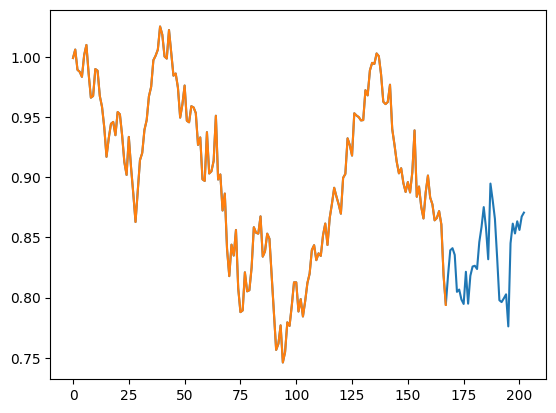

In [44]:
[plt.plot(d["Adj Close"]) for _, d in data[1:].reset_index(drop=True).groupby("Symbol")]
plt.plot(y_train)
plt.show()

In [45]:
class PositionalEncoding(nn.Module):
    def __init__(self, dims, length = 5000):
        super().__init__()

        encodings = torch.zeros(length, dims)
        position = torch.arange(0, length, dtype=torch.float).unsqueeze(1)
        divisor = torch.exp(torch.arange(0, dims, 2).float() * (-math.log(10000.0) / dims))

        encodings[:, 0::2] = torch.sin(position * divisor)
        encodings[:, 1::2] = torch.cos(position * divisor)
        self.register_buffer("encodings", encodings.unsqueeze(0).transpose(0, 1))

    def forward(self, x):
        return x + self.encodings[:x.size(0), :]

In [46]:
class TimeSeriesTransformer(nn.Module):
    def __init__(self, features = 128, dropout = 0.2):
        super().__init__()

        self.num_features = features
        self.pos_encoder = PositionalEncoding(features)
        encoderLayer = nn.TransformerEncoderLayer(d_model=features, nhead=8, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoderLayer, 1)
        self.transformer_decoder = nn.Linear(features, 1)

    def forward(self, inputs):
        source = torch.zeros(self.num_features)
        source[:len(inputs)] = inputs

        mask = self._generate_square_subsequent_mask(self.num_features)
        source = self.pos_encoder(source)
        out = self.transformer_encoder(source, mask)
        return self.transformer_decoder(out)

    @staticmethod
    def _generate_square_subsequent_mask(length):
        mask = (torch.triu(torch.ones(length, length)) == 1).transpose(0, 1)
        return mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))

In [47]:
def train(model, x_data, y_data, optimizer, criterion):
    model.train()
    total_loss = 0

    for x, y in zip(x_data, y_data):
        source, target = x.to(torch.float32), y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(source)

        loss = criterion(outputs, target) ** 0.5
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss


In [48]:
def validate(model, x_data, y_data, optimizer, criterion):
    model.eval()
    total_loss = 0

    for x, y in zip(x_data, y_data):
        source, target = x.to(torch.float32), y.to(torch.float32)
        optimizer.zero_grad()
        outputs = model(source)

        loss = criterion(outputs, target) ** 0.5
        total_loss += loss.item()

    return total_loss

In [60]:
model = TimeSeriesTransformer(BATCH_SIZE, 0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.MSELoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
EPOCHS = 500

for epoch in range(EPOCHS + 1):
    training_loss = train(model, x_train_dataloader, y_train_dataloader, optimizer, criterion)
    validation_loss = validate(model, x_test_dataloader, y_test_dataloader, optimizer, criterion)
    scheduler.step()
    if epoch % 10 == 0:
        print(f"EPOCH: {epoch}, Training Loss: {training_loss}, Validation Loss: {validation_loss}")

C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
C:\Users\Connor\Documents\School\CS7637\venv\lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([16, 1, 1])). This will likely lead to incorrect results due to bro

EPOCH: 0, Training Loss: 6.192806527018547, Validation Loss: 0.2518610432744026
EPOCH: 10, Training Loss: 0.9337047412991524, Validation Loss: 0.5174911022186279
EPOCH: 20, Training Loss: 0.9694732539355755, Validation Loss: 0.5204035192728043
EPOCH: 30, Training Loss: 0.8617184348404408, Validation Loss: 0.4951498955488205
EPOCH: 40, Training Loss: 0.8804477155208588, Validation Loss: 0.47293663769960403
EPOCH: 50, Training Loss: 0.8582578487694263, Validation Loss: 0.4873533993959427
EPOCH: 60, Training Loss: 0.8091610707342625, Validation Loss: 0.4734003469347954
EPOCH: 70, Training Loss: 0.8008895814418793, Validation Loss: 0.4567616432905197
EPOCH: 80, Training Loss: 0.8137397952377796, Validation Loss: 0.449287585914135
EPOCH: 90, Training Loss: 0.8294177539646626, Validation Loss: 0.4546501636505127
EPOCH: 100, Training Loss: 0.7862398624420166, Validation Loss: 0.4541025161743164
EPOCH: 110, Training Loss: 0.7833742126822472, Validation Loss: 0.4521021544933319
EPOCH: 120, Trai

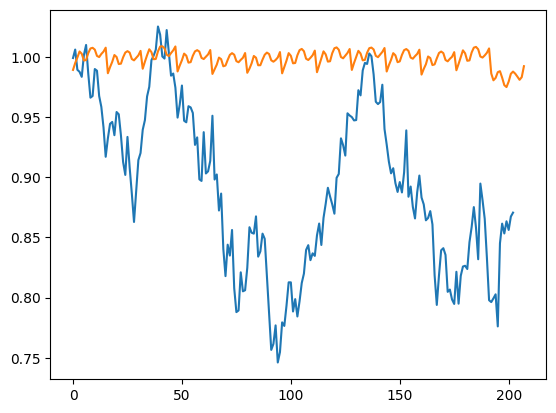

In [61]:
dataloader = DataLoader(data["Adj Close"].to_numpy(), batch_size=BATCH_SIZE)
model.eval()

predictions = []
for d in dataloader:
    predictions.append(model(d.to(torch.float32)).squeeze().detach().numpy())

[plt.plot(d["Adj Close"]) for _, d in data[1:].reset_index(drop=True).groupby("Symbol")]
# plt.plot(y_train)
plt.plot(np.concatenate(predictions))
plt.show()